In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, f_oneway, pearsonr, spearmanr, chi2

In [40]:
# 1. Load Data
df = pd.read_excel("ADHD_data.xlsx")
print("Before Cleaning Data Preview:")
print(df.head())

Before Cleaning Data Preview:
        date  sleep quality  sleep length  caffeine consumption  stress level  \
0 2025-03-06              6             5                   210             4   
1 2025-03-07              8             6                   105             7   
2 2025-03-08              8             7                   105             3   
3 2025-03-09              7             7                   105             9   
4 2025-03-13              7             6                   150             7   

  location  ambient sound level music study window  \
0  library                  NaN    no          NaN   
1     home                  NaN    no    afternoon   
2     home                 59.0    no    afternoon   
3     home                 60.0   yes    afternoon   
4     dorm                 57.0   yes        night   

   maximum duration of undisrupted focus  
0                                     32  
1                                     27  
2                            

In [41]:
# 2. Data Cleaning

# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')  # Handle errors if any date is malformed

# Convert 'music' column: map 'yes' -> 1, 'no' -> 0, fill missing with 0, then to int
df['music'] = df['music'].map({'yes': 1, 'no': 0}).fillna(0).astype(int)

# Fill missing values in numeric columns with their mean
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    df[col] = df[col].fillna(df[col].mean())

# Fill missing values in categorical/boolean columns with their mode
for col in df.select_dtypes(include=['object', 'bool', 'category']).columns:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].mode()[0])

# Final checks
print("Final Data Preview:")
print(df.head())
print("\nMissing Values After Cleaning:")
print(df.isnull().sum())


Final Data Preview:
        date  sleep quality  sleep length  caffeine consumption  stress level  \
0 2025-03-06              6             5                   210             4   
1 2025-03-07              8             6                   105             7   
2 2025-03-08              8             7                   105             3   
3 2025-03-09              7             7                   105             9   
4 2025-03-13              7             6                   150             7   

  location  ambient sound level  music study window  \
0  library             54.95122      0        night   
1     home             54.95122      0    afternoon   
2     home             59.00000      0    afternoon   
3     home             60.00000      1    afternoon   
4     dorm             57.00000      1        night   

   maximum duration of undisrupted focus  
0                                     32  
1                                     27  
2                                

In [42]:
# 3. Data Enrichment

# Create stimulation load (normalized sum of caffeine and stress)
df['stimulation load'] = (
    (df['caffeine consumption'] - df['caffeine consumption'].mean()) / df['caffeine consumption'].std()
    + (df['stress level'] - df['stress level'].mean()) / df['stress level'].std()
)

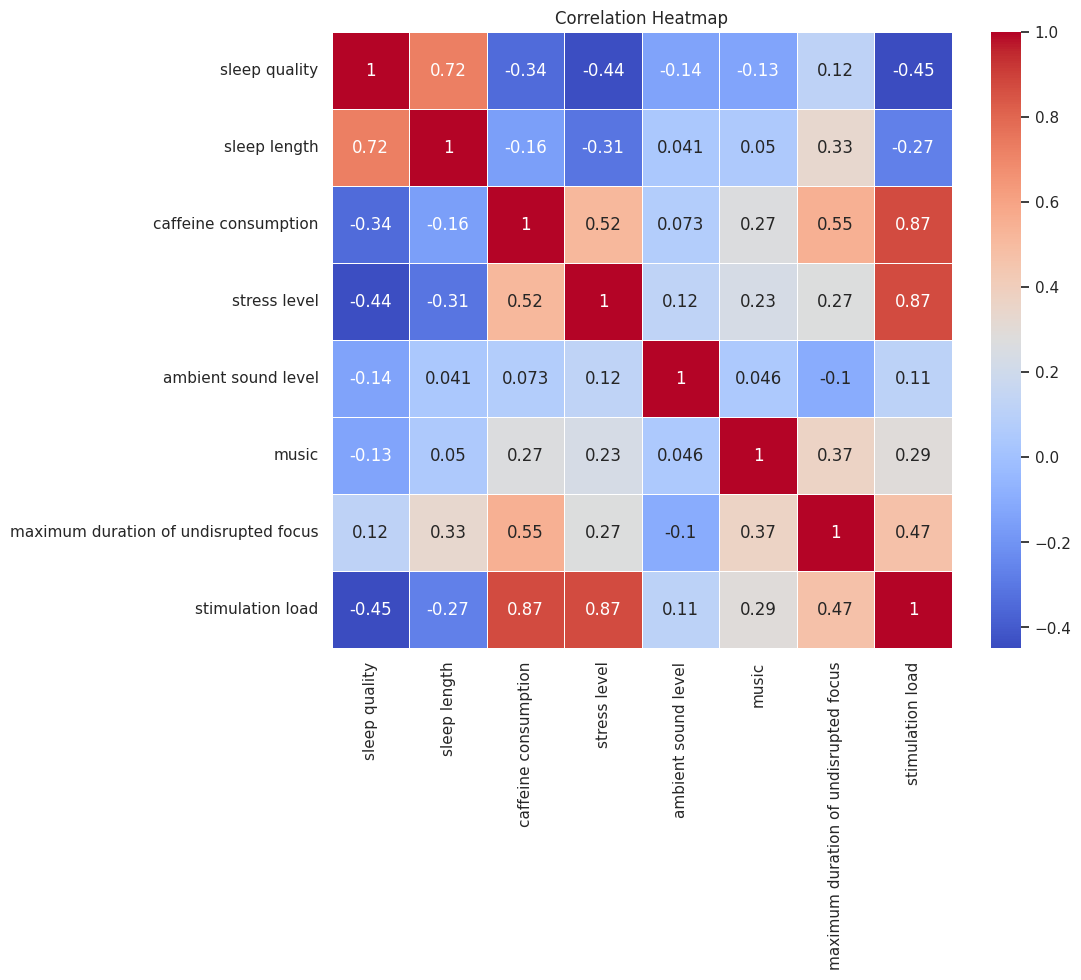


╭───────────────────────────────────────────────────────────────────────-─────╮
│  Commentary:                                                                │
│   Key take‑aways from the correlation heat‑map:                             │
│ • Better sleep goes hand‑in‑hand with longer focus – both sleep quality     │
│  ( +0.12 ) and especially sleep length ( +0.33 ) show the strongest positive│
│   links to my maximum focus time.                                           │
│ • Stress and caffeine travel together ( +0.52 ) and both pull focus in the  │
│   opposite direction (stress –0.27, caffeine –0.16). Their combined         │
│   ‘stimulation load’ has the clearest negative tie to focus ( –0.45 ).      │
│ • Ambient sound and music hardly move the needle either way (< ±0.2).       │
│ • Sleep quality and length are themselves tightly related ( +0.72 ), so     │
│  improving either one likely helps the other—and, by extension, my focus.   │
│                                      

In [43]:
# Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.savefig("corr_matrix.png", dpi=300, bbox_inches='tight')  # Save with good quality

plt.show()
print("""
╭───────────────────────────────────────────────────────────────────────-─────╮
│  Commentary:                                                                │
│   Key take‑aways from the correlation heat‑map:                             │
│ • Better sleep goes hand‑in‑hand with longer focus – both sleep quality     │
│  ( +0.12 ) and especially sleep length ( +0.33 ) show the strongest positive│
│   links to my maximum focus time.                                           │
│ • Stress and caffeine travel together ( +0.52 ) and both pull focus in the  │
│   opposite direction (stress –0.27, caffeine –0.16). Their combined         │
│   ‘stimulation load’ has the clearest negative tie to focus ( –0.45 ).      │
│ • Ambient sound and music hardly move the needle either way (< ±0.2).       │
│ • Sleep quality and length are themselves tightly related ( +0.72 ), so     │
│  improving either one likely helps the other—and, by extension, my focus.   │
│                                                                             │
│                                                                             │
│ Conclusion: prioritising good, long sleep looks like the most reliable way  │
│ to extend undistracted focus, while keeping stress and caffeine in check    │
│ should prevent steep drop‑offs.”                                            │
╰─────────────────────────────────────────────────────────────────────────-───╯
""")

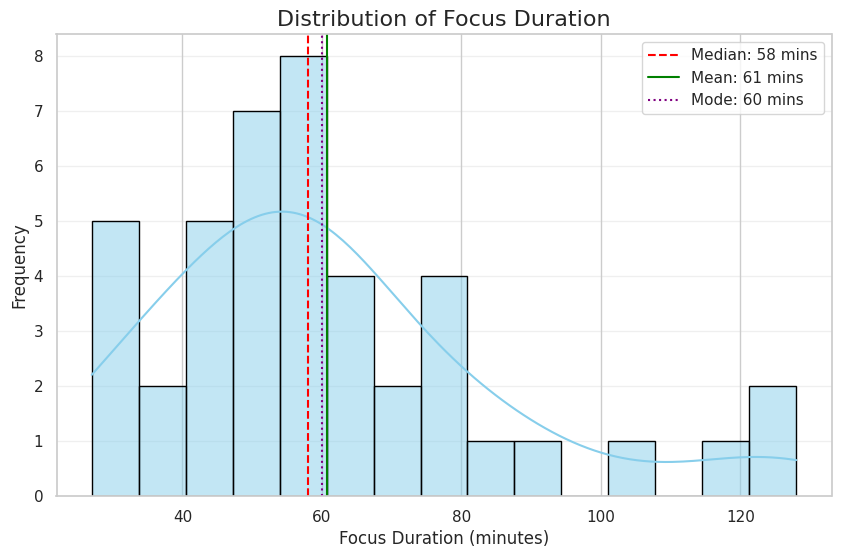


╭───────────────────────────────────────────────────────────────────────-─────╮
│  Commentary:                                                                │
│  This histogram is used to analyze the distribution of daily maximum        │
│  focus durations, giving insight into the central tendency and spread of    │
│  the focus data.                                                            │       
│                                                                             │
│  1. Below-Benchmark Sessions (Sub-60 minutes)                               │
│  These reduced focus durations strongly imply the presence of impairing     │
│  influences that require systematic review. The shortened sessions typically│
│  reflect compromised cognitive conditions that diminish sustained attention │
│  capacity.                                                                  │
│                                                                             │
│  2. Above-Benchmark Sessions (

In [47]:
# Univariate Analysis

# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="maximum duration of undisrupted focus", bins=15, kde=True, color='skyblue', edgecolor='black')

plt.title("Distribution of Focus Duration", fontsize=16)
plt.xlabel("Focus Duration (minutes)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='y', alpha=0.3)

# statistical lines
median_focus = df["maximum duration of undisrupted focus"].median()
mean_focus = df["maximum duration of undisrupted focus"].mean()
mode_focus = df["maximum duration of undisrupted focus"].mode()[0]  # Take first mode if multimodal

plt.axvline(median_focus, color='red', linestyle='--', label=f'Median: {median_focus:.0f} mins')
plt.axvline(mean_focus, color='green', linestyle='-', label=f'Mean: {mean_focus:.0f} mins')
plt.axvline(mode_focus, color='purple', linestyle=':', label=f'Mode: {mode_focus:.0f} mins')

plt.legend()
plt.savefig("univariate.png", dpi=300, bbox_inches='tight')
plt.show()

print("""
╭───────────────────────────────────────────────────────────────────────-─────╮
│  Commentary:                                                                │
│  This histogram is used to analyze the distribution of daily maximum        │
│  focus durations, giving insight into the central tendency and spread of    │
│  the focus data.                                                            │
│                                                                             │
│  1. Below-Benchmark Sessions (Sub-60 minutes)                               │
│  These reduced focus durations strongly imply the presence of impairing     │
│  influences that require systematic review. The shortened sessions typically│
│  reflect compromised cognitive conditions that diminish sustained attention │
│  capacity.                                                                  │
│                                                                             │
│  2. Above-Benchmark Sessions (Super-60 minutes)                             │
│  These extended durations demonstrate the achievement of superior focus     │
│  states, suggesting the existence of particularly effective study conditions│
│  that warrant documentation and potential reproduction.                     │
╰─────────────────────────────────────────────────────────────────────────-───╯
""")

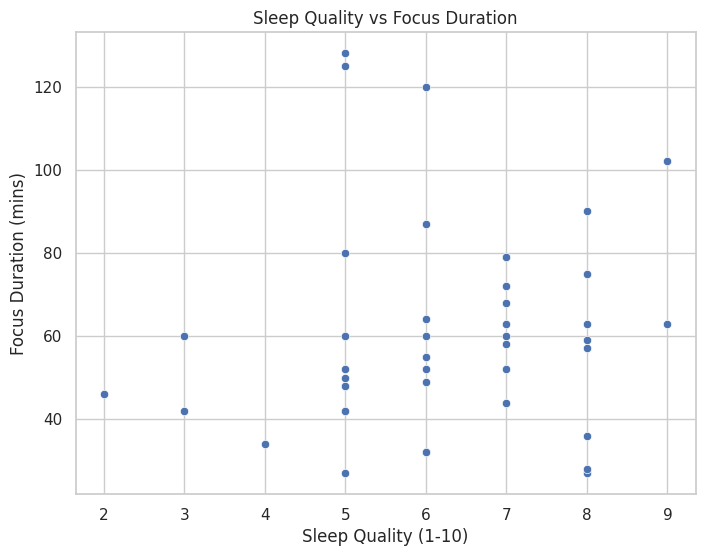


Insight: There's a general upward trend indicating higher sleep quality may be associated with longer focus durations.



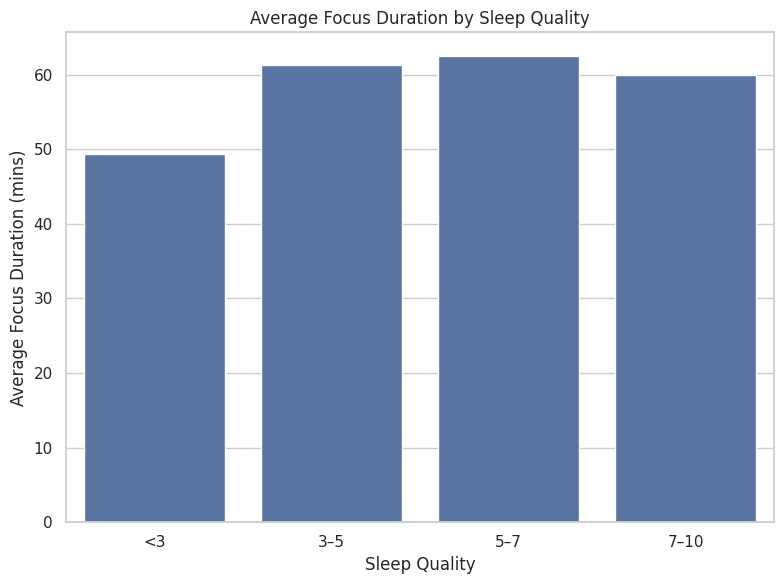


╭────────────────────────────────────────────────────────────────────────────╮
│  Commentary:                                                               │
│  Sleep Quality x Focus Duration                                            │
│                                                                            │
│  While the results aren’t entirely conclusive, the graph suggests a        │
│  potential threshold effect. Specifically, when sleep quality drops below  │
│  a certain level (e.g., less than 3), focus duration noticeably decreases. │
│  While higher sleep quality doesn’t always guarantee significantly longer  │
│  focus, extremely poor sleep quality seems to correlate with shorter focus │
│  spans.                                                                    │
╰────────────────────────────────────────────────────────────────────────────╯



In [48]:
# Bivariate Analysis

# Sleep Quality vs Focus Scatterplot --------------------------------------------------------------------------------------------------------------------------
plt.figure(figsize=(8, 6))
sns.scatterplot(x='sleep quality', y='maximum duration of undisrupted focus', data=df)
plt.title('Sleep Quality vs Focus Duration')
plt.xlabel('Sleep Quality (1-10)')
plt.ylabel('Focus Duration (mins)')
plt.savefig("sleep_quality.png", dpi=300, bbox_inches='tight')  # Save with good quality

plt.show()
print("")
print("Insight: There's a general upward trend indicating higher sleep quality may be associated with longer focus durations.")
print("")

# Sleep quality x Focus Duration Bins
df['sleep_quality_bin'] = pd.cut(df['sleep quality'], bins=[0, 3, 5, 7, 10], labels=['<3', '3–5', '5–7', '7–10'])

sleep_quality_focus = df.groupby('sleep_quality_bin', observed=False)['maximum duration of undisrupted focus'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(x='sleep_quality_bin', y='maximum duration of undisrupted focus', data=sleep_quality_focus)
plt.title('Average Focus Duration by Sleep Quality')
plt.xlabel('Sleep Quality')
plt.ylabel('Average Focus Duration (mins)')
plt.tight_layout()
plt.savefig("sleep_quality_bin.png", dpi=300, bbox_inches='tight')  # Save with good quality

plt.show()
print("""
╭────────────────────────────────────────────────────────────────────────────╮
│  Commentary:                                                               │
│  Sleep Quality x Focus Duration                                            │
│                                                                            │
│  While the results aren’t entirely conclusive, the graph suggests a        │
│  potential threshold effect. Specifically, when sleep quality drops below  │
│  a certain level (e.g., less than 3), focus duration noticeably decreases. │
│  While higher sleep quality doesn’t always guarantee significantly longer  │
│  focus, extremely poor sleep quality seems to correlate with shorter focus │
│  spans.                                                                    │
╰────────────────────────────────────────────────────────────────────────────╯
""")

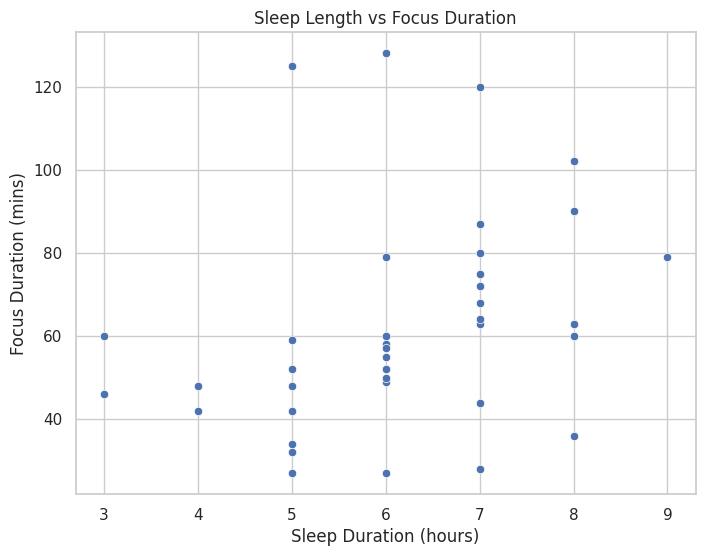

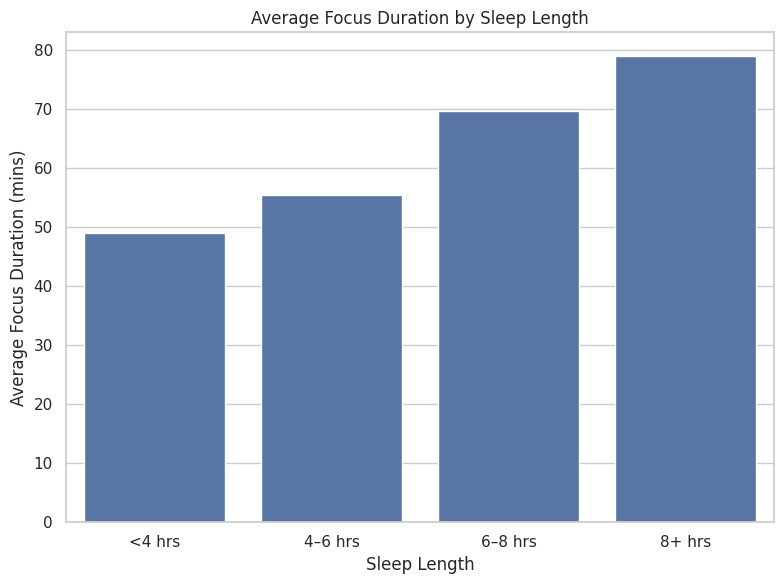


╭────────────────────────────────────────────────────────────────────────────╮
│ Commentary:                                                                │
│ Sleep Length x Focus Duration                                              │
│ The analysis suggests a positive association between sleep quality         │
│ and focus duration. Although variability exists, it can be observed that   │
│ the more sleep I have gotten, my undisrupted focus duration has increased  │
│ as well.                                                                   │
╰────────────────────────────────────────────────────────────────────────────╯



In [49]:

# Sleep Length vs Focus Scatterplot--------------------------------------------------------------------------------------------------------------------------
plt.figure(figsize=(8, 6))
sns.scatterplot(x='sleep length', y='maximum duration of undisrupted focus', data=df)
plt.title('Sleep Length vs Focus Duration')
plt.xlabel('Sleep Duration (hours)')
plt.ylabel('Focus Duration (mins)')
plt.savefig("sleep_length.png", dpi=300, bbox_inches='tight')  # Save with good quality
plt.show()


# Sleep Length x Focus Duration Bins

df['sleep_length_bin'] = pd.cut(df['sleep length'], bins=[0, 4, 6, 8, 10], labels=['<4 hrs', '4–6 hrs', '6–8 hrs', '8+ hrs'])

sleep_length_focus = df.groupby('sleep_length_bin', observed=False)['maximum duration of undisrupted focus'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(x='sleep_length_bin', y='maximum duration of undisrupted focus', data=sleep_length_focus)
plt.title('Average Focus Duration by Sleep Length')
plt.xlabel('Sleep Length')
plt.ylabel('Average Focus Duration (mins)')
plt.tight_layout()
plt.savefig("sleep_length_bin.png", dpi=300, bbox_inches='tight')  # Save with good quality
plt.show()

print("""
╭────────────────────────────────────────────────────────────────────────────╮
│ Commentary:                                                                │
│ Sleep Length x Focus Duration                                              │
│ The analysis suggests a positive association between sleep quality         │
│ and focus duration. Although variability exists, it can be observed that   │
│ the more sleep I have gotten, my undisrupted focus duration has increased  │
│ as well.                                                                   │
╰────────────────────────────────────────────────────────────────────────────╯
""")


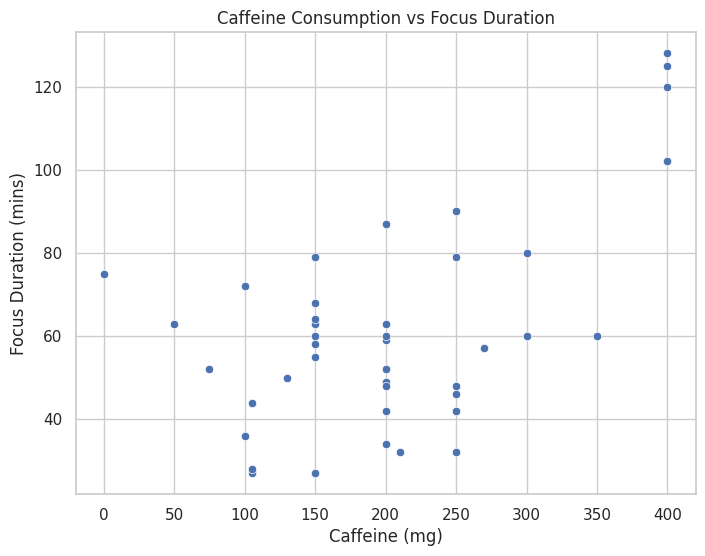

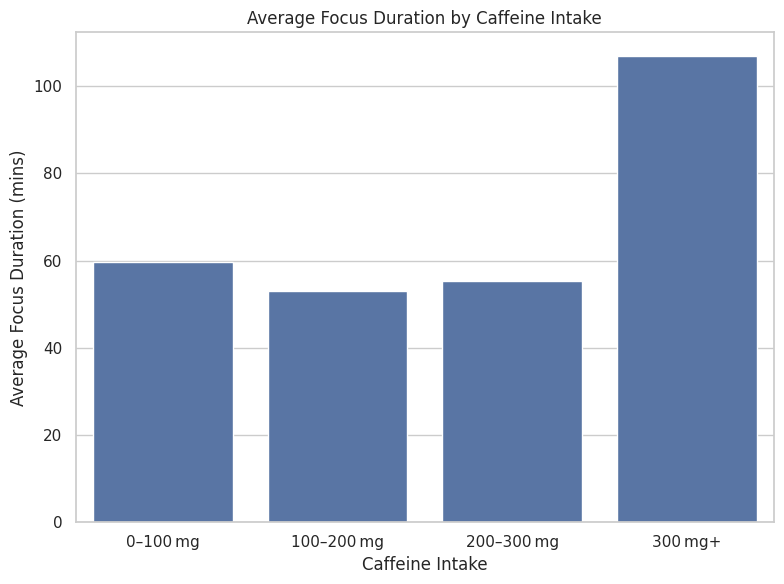


╭────────────────────────────────────────────────────────────────────────────╮
│ Commentary:                                                                │
│ Caffeine x Focus Duration                                                  │
│ The relationship seems nonlinear — higher caffeine doesn't always mean     │
│ longer focus. In fact, some of my best focus durations happened at very    │
│ low or very high caffeine levels, while moderate doses often led to shorter│
│ sessions. This suggests other factors like sleep, stress, or environment   │
│ may be influencing my ability to focus more than caffeine alone.           │
╰────────────────────────────────────────────────────────────────────────────╯



In [58]:
# Caffeine vs Focus Scatterplot --------------------------------------------------------------------------------------------------------------------------
plt.figure(figsize=(8, 6))
sns.scatterplot(x='caffeine consumption', y='maximum duration of undisrupted focus', data=df)
plt.title('Caffeine Consumption vs Focus Duration')
plt.xlabel('Caffeine (mg)')
plt.ylabel('Focus Duration (mins)')
plt.savefig("caffeine.png", dpi=300, bbox_inches='tight')  # Save with good quality
plt.show()


# Caffeine x Sleep Length Interaction Bins

df['caffeine_bin'] = pd.cut(
    df['caffeine consumption'],
    bins=[-0.1, 100, 200, 300, 500],
    labels=['0–100 mg', '100–200 mg', '200–300 mg', '300 mg+']
)

caff_focus = (
    df.groupby('caffeine_bin', observed=False)['maximum duration of undisrupted focus']
    .mean()
    .reset_index()
)


plt.figure(figsize=(8, 6))
sns.barplot(x='caffeine_bin', y='maximum duration of undisrupted focus', data=caff_focus)
plt.title('Average Focus Duration by Caffeine Intake')
plt.xlabel('Caffeine Intake')
plt.ylabel('Average Focus Duration (mins)')
plt.tight_layout()
plt.savefig("caffeine_bin.png", dpi=300, bbox_inches='tight')  # Save with good quality

plt.show()


print("""
╭────────────────────────────────────────────────────────────────────────────╮
│ Commentary:                                                                │
│ Caffeine x Focus Duration                                                  │
│ The relationship seems nonlinear — higher caffeine doesn't always mean     │
│ longer focus. In fact, some of my best focus durations happened at very    │
│ low or very high caffeine levels, while moderate doses often led to shorter│
│ sessions. This suggests other factors like sleep, stress, or environment   │
│ may be influencing my ability to focus more than caffeine alone.           │
╰────────────────────────────────────────────────────────────────────────────╯
""")



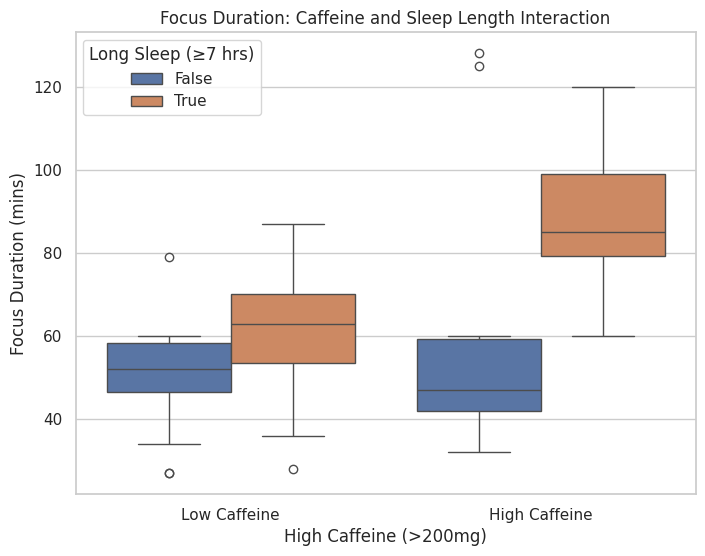


╭────────────────────────────────────────────────────────────────────────────╮
│ Commentary:                                                                │
│ Caffeine x Sleep Length x Focus Duration Relationship                      │
│                                                                            │
│ Focus duration is highest when high caffeine intake is paired with long    │
│ sleep. Without enough sleep, high caffeine doesn't boost focus—and might   │
│ even reduce it. This suggests a nonlinear effect: caffeine helps most when │
│ you're well-rested.                                                        │
╰────────────────────────────────────────────────────────────────────────────╯



In [54]:
# Caffeine x Sleep Length Interaction Boxplots
df['high_caffeine'] = df['caffeine consumption'] > 200
df['long_sleep'] = df['sleep length'] >= 7

plt.figure(figsize=(8, 6))
sns.boxplot(x='high_caffeine', y='maximum duration of undisrupted focus', hue='long_sleep', data=df)
plt.title('Focus Duration: Caffeine and Sleep Length Interaction')
plt.xlabel('High Caffeine (>200mg)')
plt.ylabel('Focus Duration (mins)')
plt.xticks([0, 1], ['Low Caffeine', 'High Caffeine'])
plt.legend(title='Long Sleep (≥7 hrs)')
plt.savefig("caffeine_sleep_interaction.png", dpi=300, bbox_inches='tight')

plt.show()

print("""
╭────────────────────────────────────────────────────────────────────────────╮
│ Commentary:                                                                │
│ Caffeine x Sleep Length x Focus Duration Relationship                      │
│                                                                            │
│ Focus duration is highest when high caffeine intake is paired with long    │
│ sleep. Without enough sleep, high caffeine doesn't boost focus—and might   │
│ even reduce it. This suggests a nonlinear effect: caffeine helps most when │
│ you're well-rested.                                                        │
╰────────────────────────────────────────────────────────────────────────────╯
""")

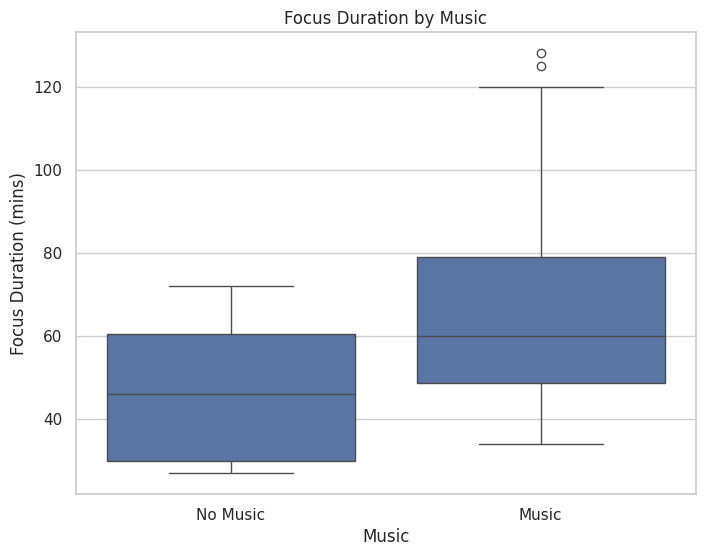


╭────────────────────────────────────────────────────────────────────────────╮
│ Commentary:                                                                │
│ Music x Focus Duration                                                     │
│                                                                            │
│ It can be observed that listening to music might have a slight advantage   │
│ in focus duration, however more analysis is needed !                       │
╰────────────────────────────────────────────────────────────────────────────╯



In [55]:
# Music vs Focus Boxplots--------------------------------------------------------------------------------------------------------------------------
plt.figure(figsize=(8, 6))
sns.boxplot(x='music', y='maximum duration of undisrupted focus', data=df)
plt.title('Focus Duration by Music')
plt.xlabel('Music')
plt.ylabel('Focus Duration (mins)')
plt.xticks([0, 1], ['No Music', 'Music'])
plt.savefig("music.png", dpi=300, bbox_inches='tight')  # Save with good quality

plt.show()
print("""
╭────────────────────────────────────────────────────────────────────────────╮
│ Commentary:                                                                │
│ Music x Focus Duration                                                     │
│                                                                            │
│ It can be observed that listening to music might have a slight advantage   │
│ in focus duration, however more analysis is needed !                       │
╰────────────────────────────────────────────────────────────────────────────╯
""")



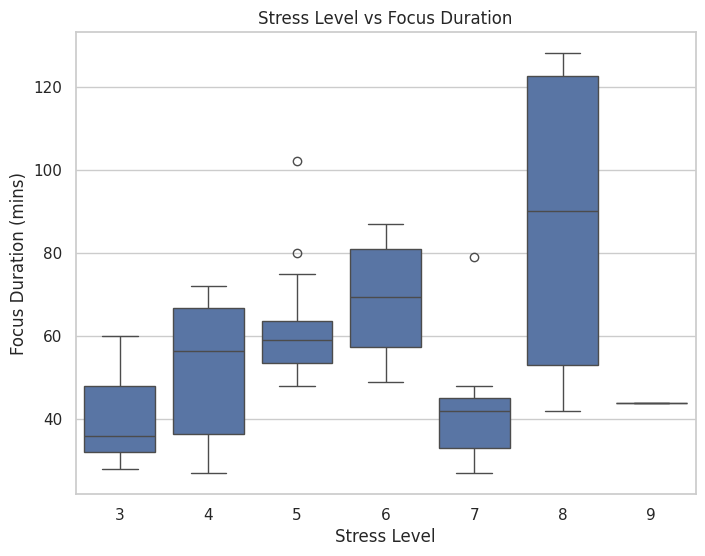


╭───────────────────────────────────────────────────────────────────────-─────╮
│  Commentary:                                                                │
│  Stress Level x Focus Duration                                              │
│                                                                             │
│  Moving from stress 3 to 4, my median focus length actually rises, hinting  │
│  that a little pressure can sharpen attention. Around levels 5–6 the benefit│
│  flattens out, focus neither improves nor worsens much, before dropping     │
│  sharply from level 7 onward. Most high‑stress sessions are short and       │
│  erratic, yet one exceptional 125‑minute burst at stress 8 shows that       │
│  extreme pressure can occasionally trigger my ADHD hyper‑focus. Overall,    │
│  mild‑to‑moderate stress helps, but excessive stress generally negatively   │
│  affects my undisruped focus length.                                        │
│                                      

In [61]:
# Stress vs Focus Boxplots --------------------------------------------------------------------------------------------------------------------------
plt.figure(figsize=(8, 6))
sns.boxplot(x='stress level', y='maximum duration of undisrupted focus', data=df)
plt.title('Stress Level vs Focus Duration')
plt.xlabel('Stress Level')
plt.ylabel('Focus Duration (mins)')
plt.savefig("stress.png", dpi=300, bbox_inches='tight')  # Save with good quality

plt.show()



print("""
╭───────────────────────────────────────────────────────────────────────-─────╮
│  Commentary:                                                                │
│  Stress Level x Focus Duration                                              │
│                                                                             │
│  Moving from stress 3 to 4, my median focus length actually rises, hinting  │
│  that a little pressure can sharpen attention. Around levels 5–6 the benefit│
│  flattens out, focus neither improves nor worsens much, before dropping     │
│  sharply from level 7 onward. Most high‑stress sessions are short and       │
│  erratic, yet one exceptional 125‑minute burst at stress 8 shows that       │
│  extreme pressure can occasionally trigger my ADHD hyper‑focus. Overall,    │
│  mild‑to‑moderate stress helps, but excessive stress generally negatively   │
│  affects my undisruped focus length.                                        │
│                                                                             │
╰─────────────────────────────────────────────────────────────────────────-───╯
""")


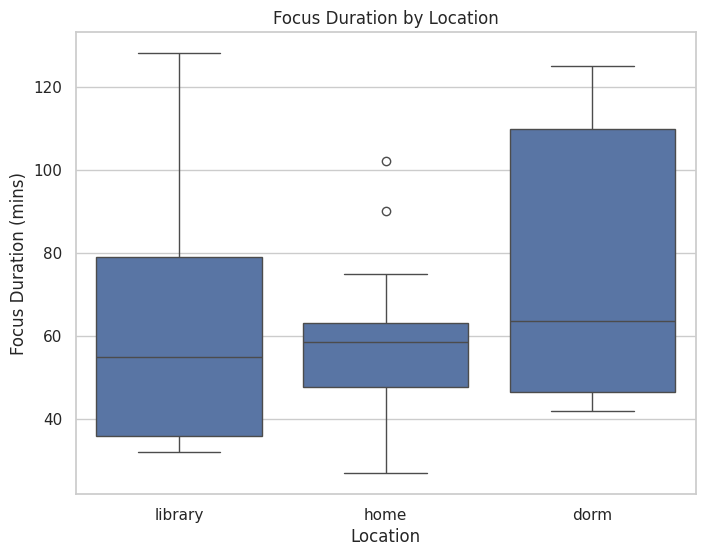


╭───────────────────────────────────────────────────────────────────────-─────╮
│  Commentary:                                                                │
│  Study Location x Focus Duration                                            │
│  The data suggests that I tend to focus longer at the dorm on average,      │
│  followed by the library, while home consistently had the shortest and most │
│  clustered focus times. The dorm and library also show more variability,    │
│  with some notably high durations. These results may reflect environmental  │
│  distractions or comfort levels in each location.An ANOVA test was performed│
│  to see if these differences are statistically significant.                 │
╰─────────────────────────────────────────────────────────────────────────-───╯



In [62]:

# Location vs Focus Boxplots --------------------------------------------------------------------------------------------------------------------------
plt.figure(figsize=(8, 6))
sns.boxplot(x='location', y='maximum duration of undisrupted focus', data=df)
plt.title('Focus Duration by Location')
plt.xlabel('Location')
plt.ylabel('Focus Duration (mins)')
plt.savefig("location.png", dpi=300, bbox_inches='tight')  # Save with good quality

plt.show()
print("""
╭───────────────────────────────────────────────────────────────────────-─────╮
│  Commentary:                                                                │
│  Study Location x Focus Duration                                            │
│  The data suggests that I tend to focus longer at the dorm on average,      │
│  followed by the library, while home consistently had the shortest and most │
│  clustered focus times. The dorm and library also show more variability,    │
│  with some notably high durations. These results may reflect environmental  │
│  distractions or comfort levels in each location.An ANOVA test was performed│
│  to see if these differences are statistically significant.                 │
╰─────────────────────────────────────────────────────────────────────────-───╯
""")


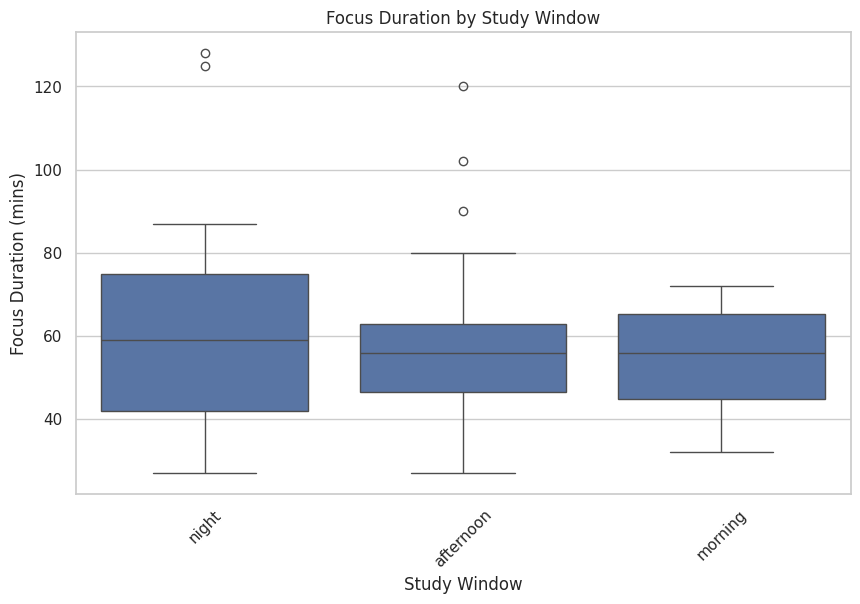


╭───────────────────────────────────────────────────────────────────────-─────╮
│  Commentary:                                                                │
│  Study Window x Focus Duration                                              │
│  Study timing may influence attention spans; some windows like night may    │
│  have better outcomes.                                                      │
╰─────────────────────────────────────────────────────────────────────────-───╯



In [63]:
# Study Window vs Focus Boxplots --------------------------------------------------------------------------------------------------------------------------
plt.figure(figsize=(10, 6))
sns.boxplot(x='study window', y='maximum duration of undisrupted focus', data=df)
plt.title('Focus Duration by Study Window')
plt.xlabel('Study Window')
plt.ylabel('Focus Duration (mins)')
plt.xticks(rotation=45)
plt.savefig("study_window_focus.png", dpi=300, bbox_inches='tight')  # Save with good quality
plt.show()

print("""
╭───────────────────────────────────────────────────────────────────────-─────╮
│  Commentary:                                                                │
│  Study Window x Focus Duration                                              │
│  Study timing may influence attention spans; some windows like night may    │
│  have better outcomes.                                                      │
╰─────────────────────────────────────────────────────────────────────────-───╯
""")


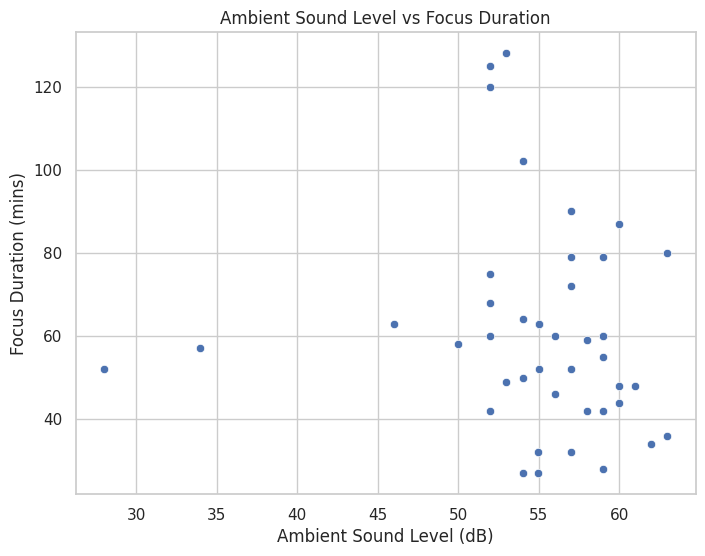

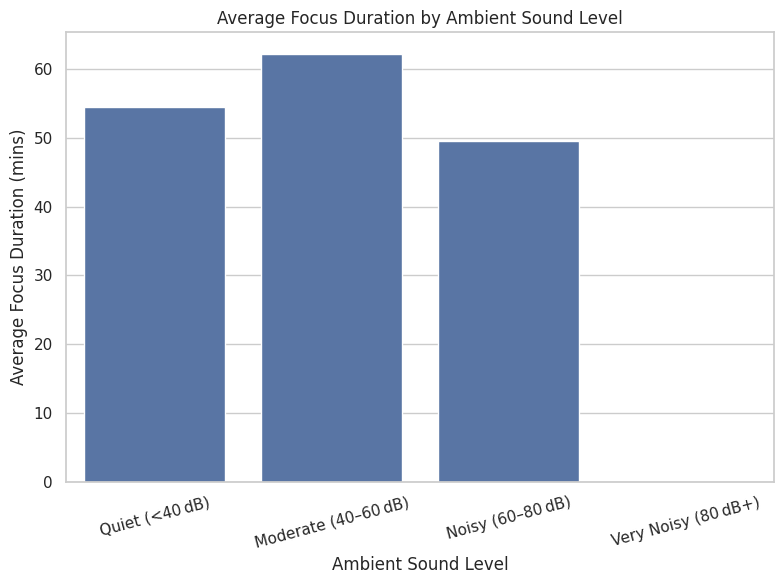


╭───────────────────────────────────────────────────────────────────────-─────╮
│  Commentary:                                                                │
│  Ambient Sound x Focus Duration                                             │
│  It can be observed that very noisy environments might negatively impact    │
│  focus, while moderate sound levels could have neutral or slightly positive │
│  effects.                                                                   │
╰─────────────────────────────────────────────────────────────────────────-───╯



In [64]:

# Ambient Sound vs Focus Duration Scatterplot ------------------------------------------------------------------------------------------------------------------
plt.figure(figsize=(8, 6))
sns.scatterplot(x='ambient sound level', y='maximum duration of undisrupted focus', data=df)
plt.title('Ambient Sound Level vs Focus Duration')
plt.xlabel('Ambient Sound Level (dB)')
plt.ylabel('Focus Duration (mins)')
plt.savefig("ambient_sound.png", dpi=300, bbox_inches='tight')  # Save with good quality

plt.show()

# Ambient Sound vs Focus Duration Bins
df['sound_bin'] = pd.cut(
    df['ambient sound level'],
    bins=[-0.1, 40, 60, 80, 120],
    labels=['Quiet (<40 dB)', 'Moderate (40–60 dB)', 'Noisy (60–80 dB)', 'Very Noisy (80 dB+)']
)

sound_focus = (df.groupby('sound_bin', observed=False)
                 ['maximum duration of undisrupted focus']
                 .mean()
                 .reset_index())

plt.figure(figsize=(8, 6))
sns.barplot(x='sound_bin', y='maximum duration of undisrupted focus', data=sound_focus)
plt.title('Average Focus Duration by Ambient Sound Level')
plt.xlabel('Ambient Sound Level')
plt.ylabel('Average Focus Duration (mins)')
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig("ambient_sound_bin.png", dpi=300, bbox_inches='tight')  # Save with good quality

plt.show()

print("""
╭───────────────────────────────────────────────────────────────────────-─────╮
│  Commentary:                                                                │
│  Ambient Sound x Focus Duration                                             │
│  It can be observed that very noisy environments might negatively impact    │
│  focus, while moderate sound levels could have neutral or slightly positive │
│  effects.                                                                   │
╰─────────────────────────────────────────────────────────────────────────-───╯
""")


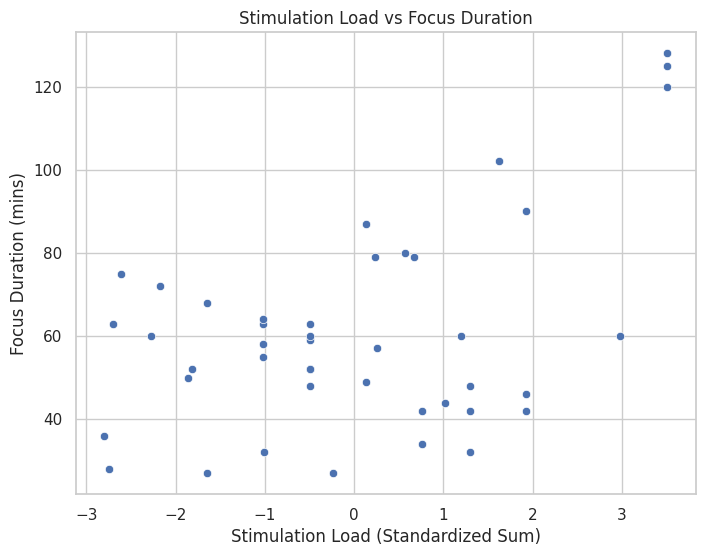


╭───────────────────────────────────────────────────────────────────────-─────╮
│  Commentary:                                                                │
│  Stimulation Load x Focus Duration                                          │
│  Focus seems to peak when my overall stimulation (stress + caffeine) sits in│
│  the middle of the range and drops off at both extremes. In other words,    │
│  a moderate buzz keeps me on‑task, but too little or too much stimulation   │
│  shortens my sessions. This suggests balance is key !                       │
╰─────────────────────────────────────────────────────────────────────────-───╯



In [65]:

# Stimulation Load vs Focus Scatterplot --------------------------------------------------------------------------------------------------------------------------
plt.figure(figsize=(8, 6))
sns.scatterplot(x='stimulation load', y='maximum duration of undisrupted focus', data=df)
plt.title('Stimulation Load vs Focus Duration')
plt.xlabel('Stimulation Load (Standardized Sum)')
plt.ylabel('Focus Duration (mins)')
plt.savefig("stimulation.png", dpi=300, bbox_inches='tight')

plt.show()

print("""
╭───────────────────────────────────────────────────────────────────────-─────╮
│  Commentary:                                                                │
│  Stimulation Load x Focus Duration                                          │
│  Focus seems to peak when my overall stimulation (stress + caffeine) sits in│
│  the middle of the range and drops off at both extremes. In other words,    │
│  a moderate buzz keeps me on‑task, but too little or too much stimulation   │
│  shortens my sessions. This suggests balance is key !                       │
╰─────────────────────────────────────────────────────────────────────────-───╯
""")


In [66]:
# 5. Hypothesis Testing

# Sleep Quality
good_sleep = df[df['sleep quality'] >= 7]['maximum duration of undisrupted focus']
poor_sleep = df[df['sleep quality'] < 5]['maximum duration of undisrupted focus']
t_stat, p_val = ttest_ind(good_sleep, poor_sleep, equal_var=False)
print("\nSleep Quality Test:")
print(f"p = {p_val:.4f}")
print("Significant" if p_val < 0.05 else "Not significant")

# Sleep Length
good_len = df[df['sleep length'] >= 7]['maximum duration of undisrupted focus']
poor_len = df[df['sleep length'] < 5]['maximum duration of undisrupted focus']
t_stat_len, p_val_len = ttest_ind(good_len, poor_len, equal_var=False)
print("\nSleep Length Test:")
print(f"p = {p_val_len:.4f}")
print("Significant" if p_val_len < 0.05 else "Not significant")


# Study Window ANOVA
groups = [group['maximum duration of undisrupted focus'].dropna() for name, group in df.groupby('study window')]
f_stat_study, p_val_study = f_oneway(*groups)
print("\nStudy Window ANOVA Test:")
print(f"p = {p_val_study:.4f}")
print("Significant" if p_val_study < 0.05 else "Not significant")

# Location ANOVA
f_stat, p_val_loc = f_oneway(
    df[df['location'] == 'home']['maximum duration of undisrupted focus'],
    df[df['location'] == 'library']['maximum duration of undisrupted focus'],
    df[df['location'] == 'dorm']['maximum duration of undisrupted focus']
)
print("\nLocation ANOVA Test:")
print(f"p = {p_val_loc:.4f}")
print("Significant" if p_val_loc < 0.05 else "Not significant")


# Caffeine Intake ANOVA
df['caffeine_quartile'] = pd.qcut(df['caffeine consumption'], 4, labels=['Q1','Q2','Q3','Q4'])

groups_caff = [
    g['maximum duration of undisrupted focus'].dropna()
    for _, g in df.groupby('caffeine_quartile', observed=True)
]
f_stat_caff, p_val_caff = f_oneway(*groups_caff)

print("\nCaffeine Intake ANOVA Test:")
print(f"p = {p_val_caff:.4f}")
print("Significant" if p_val_caff < 0.05 else "Not significant")


# Stress Level ANOVA
groups_stress = [group['maximum duration of undisrupted focus'].dropna()
                 for _, group in df.groupby('stress level')]
f_stat_stress, p_val_stress = f_oneway(*groups_stress)
print("\nStress Level ANOVA Test:")
print(f"p = {p_val_stress:.4f}")
print("Significant" if p_val_stress < 0.05 else "Not significant")

# Music vs No Music T-test
focus_music = df[df['music'] == 1]['maximum duration of undisrupted focus']
focus_no_music = df[df['music'] == 0]['maximum duration of undisrupted focus']
t_stat_music, p_val_music = ttest_ind(focus_music, focus_no_music, equal_var=False)
print("\nMusic Presence T-Test:")
print(f"p = {p_val_music:.4f}")
print("Significant" if p_val_music < 0.05 else "Not significant")

# Stimulation Load (split high vs low)
median_stim = df['stimulation load'].median()
high_stim = df[df['stimulation load'] >= median_stim]['maximum duration of undisrupted focus']
low_stim = df[df['stimulation load'] < median_stim]['maximum duration of undisrupted focus']
t_stat_stim, p_val_stim = ttest_ind(high_stim, low_stim, equal_var=False)
print("\nStimulation Load T-Test (High vs Low):")
print(f"p = {p_val_stim:.4f}")
print("Significant" if p_val_stim < 0.05 else "Not significant")


# Ambient Sound Level (Spearman Correlation Test)
sound_levels = df['ambient sound level']
focus_duration = df['maximum duration of undisrupted focus']

# Drop NaNs
valid = sound_levels.notna() & focus_duration.notna()
rho, p_val_spearman = spearmanr(sound_levels[valid], focus_duration[valid])

print("\nAmbient Sound Level (Spearman Correlation) :")
print(f"rho = {rho:.3f}, p = {p_val_spearman:.4f}")
print("Significant" if p_val_spearman < 0.05 else "Not significant")


print("\n")

# Chi Square Test to combine all p-values
# Use the p-values generated from hypothesis tests above
p_values = [
    p_val,               # Sleep Quality Test T-test
    p_val_len,           # Sleep Length Test T-test
    p_val_study,         # Study Window ANOVA Test
    p_val_loc,           # Location ANOVA Test
    p_val_caff,          # Caffeine Intake ANOVA Test
    p_val_stress,        # Stress Level ANOVA Test
    p_val_music,         # Music Presence T-Test
    p_val_stim,          # Stimulation Load T-Test
    p_val_spearman       # Ambient Sound Level (Spearman)
]

# Apply Fisher's methodmissingfrommycode
chi_statistic = -2 * np.sum(np.log(p_values))
degrees_of_freedom = 2 * len(p_values)
combined_p_value = 1 - chi2.cdf(chi_statistic, degrees_of_freedom)

print("Fisher's Combined Test Statistic (all p values taken into account):", chi_statistic)
print("Degrees of Freedom:", degrees_of_freedom)
print("Combined p-value:", combined_p_value)


# Interpretation
if combined_p_value < 0.05:
    print("Result: The combined effect of these factors on daily life is statistically significant.")
    print("Hence we reject the null hypothesis !")

else:
    print("Result: The combined effect of these factors is not statistically significant.")
    print("Hence we fail to reject the null hypothesis !")


# Save enriched dataset
df.to_csv("processed_ADHD_data.csv", index=False)


Sleep Quality Test:
p = 0.0495
Significant

Sleep Length Test:
p = 0.0064
Significant

Study Window ANOVA Test:
p = 0.8174
Not significant

Location ANOVA Test:
p = 0.2221
Not significant

Caffeine Intake ANOVA Test:
p = 0.0004
Significant

Stress Level ANOVA Test:
p = 0.0097
Significant

Music Presence T-Test:
p = 0.0054
Significant

Stimulation Load T-Test (High vs Low):
p = 0.0872
Not significant

Ambient Sound Level (Spearman Correlation) :
rho = -0.221, p = 0.1540
Not significant


Fisher's Combined Test Statistic (all p values taken into account): 63.32463329026453
Degrees of Freedom: 18
Combined p-value: 5.874348316670108e-07
Result: The combined effect of these factors on daily life is statistically significant.
Hence we reject the null hypothesis !
